In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix


import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras


Using TensorFlow backend.


In [2]:
def load_data(labels_path, tabular_path):
    # import dataframe with filenames and labels
    labels = pd.read_csv(labels_path)
    labels = labels.fillna(2)
    
    # load tabular data
    tabular = pd.read_csv(tabular_path, index_col = 0)
    
    return labels, tabular

In [3]:
def label_smoother(aerial, gsv):
    mapping = {
        (0, 0): 0,
        (1, 0): 2,
        (2, 0): 0,
        (0, 1): 2,
        (1, 1): 1,
        (2, 1): 1,
        (0, 2): 0,
        (1, 2): 1,
        (2, 2): 2
    }
    return mapping[(int(aerial), int(gsv))]

def clean_labels(labels):
    # smooth labels
    # labels = labels[~((labels['AERIAL_Driveway'] == 2) & (labels['GSV_Driveway'] == 2))]
    labels['final_label']=labels.apply(lambda x: label_smoother(x['AERIAL_Driveway'],x['GSV_Driveway']), axis = 1)
    
    return labels

In [4]:
labels_path = '../data/training/all_labels.csv'
tabular_path = '../data/residence_addresses_googlestreetview_clean.csv'

# Get training data ready
labels, tabular = load_data(labels_path, tabular_path)

labels_clean = clean_labels(labels)

In [5]:
def upsample(df):
    # upsample
    n1 = sum((df.final_label == 1) | (df.final_label == 0.9))
    n0 = sum((df.final_label == 0) | (df.final_label == 0.1))
    labels0 = df[(df.final_label == 0) | (df.final_label == 0.1)]
    labels0_upsample = labels0.sample(n1 - n0, replace = True)
    labels_all_upsampled = pd.concat([df, labels0_upsample])
    return labels_all_upsampled

In [7]:
df = labels_clean.merge(tabular)

# EDA

In [89]:
import seaborn as sns
#scaler = StandardScaler()
#df_viz = scaler.fit_transform(df.drop('MBL', axis = 1))
df_viz = pd.DataFrame(df, columns = df.columns.drop(['MBL','AERIAL_Driveway','GSV_Driveway']))
df_viz = upsample(df_viz)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


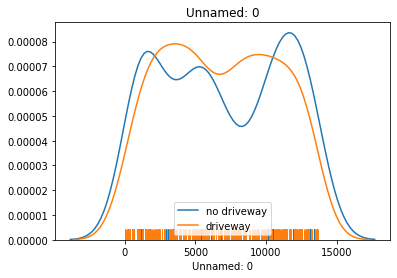

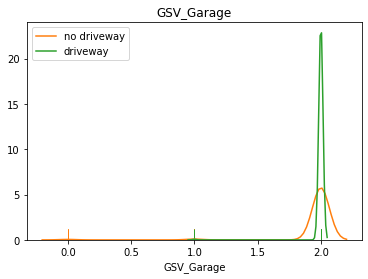

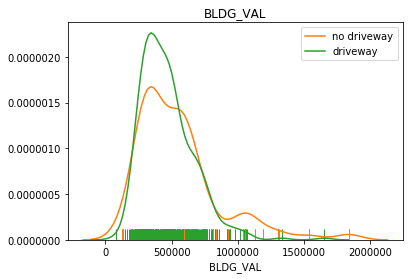

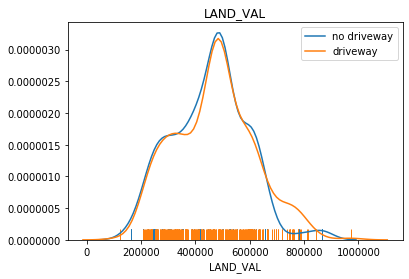

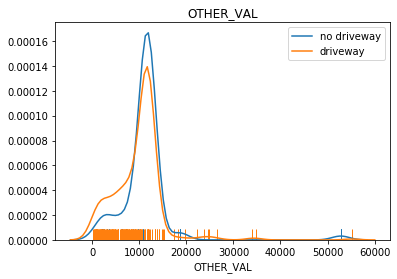

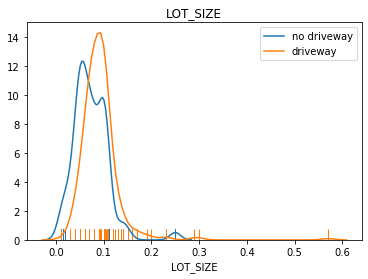

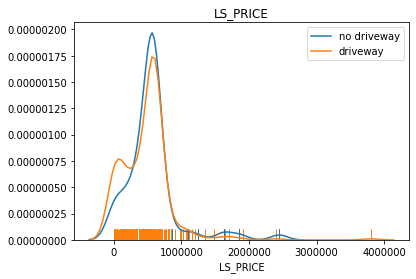

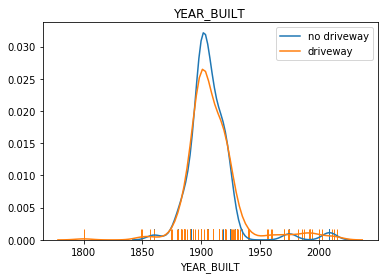

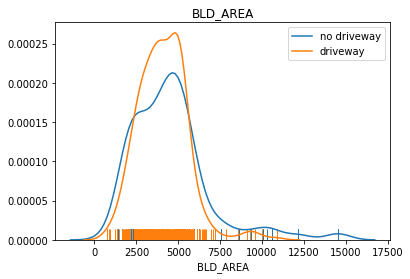

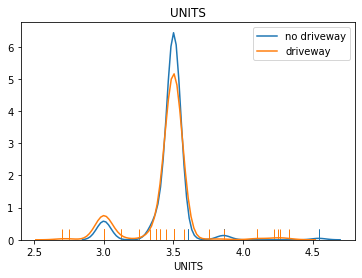

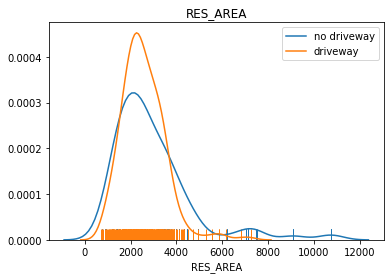

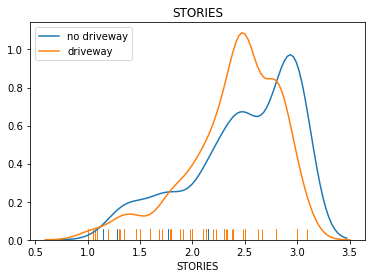

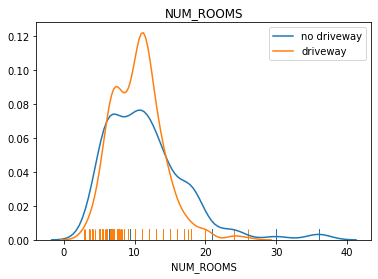

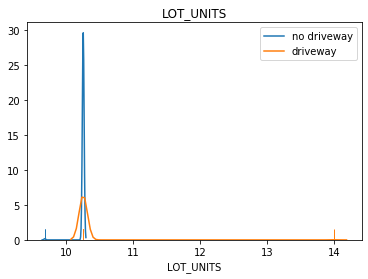

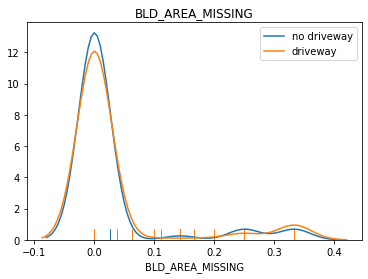

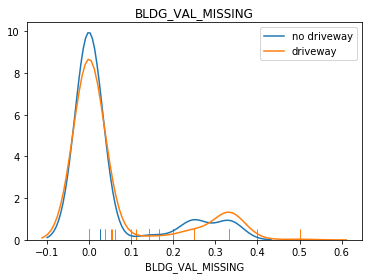

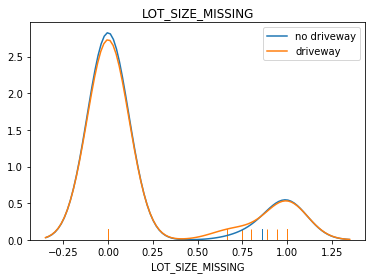

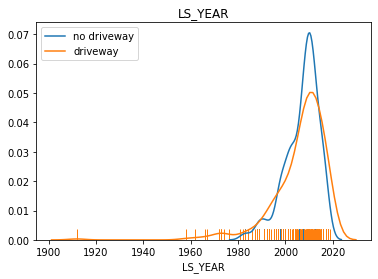

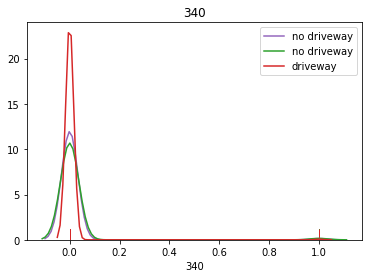

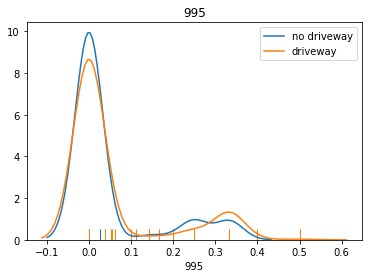

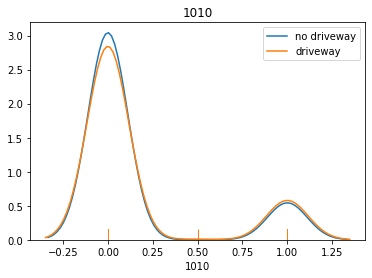

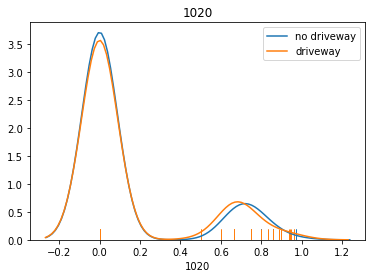

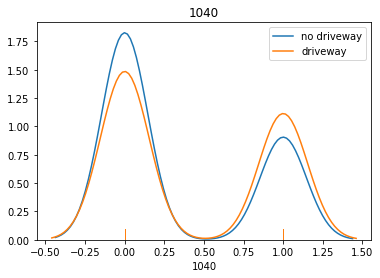

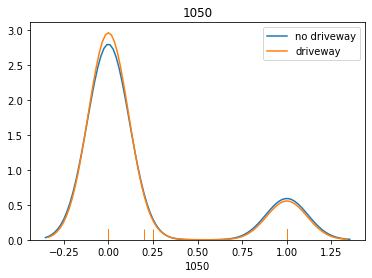

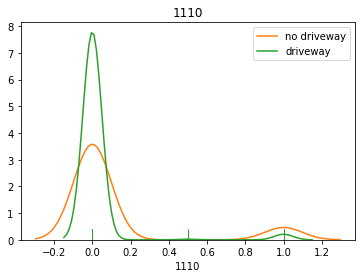

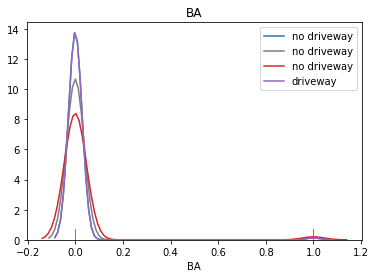

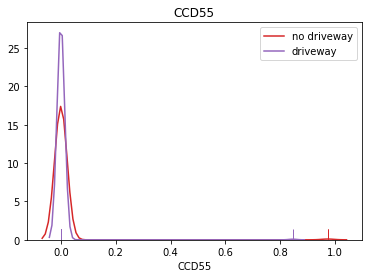

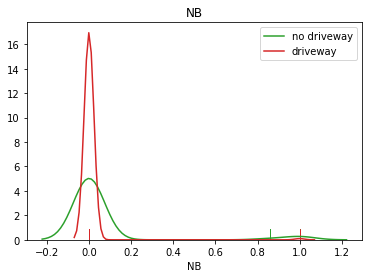

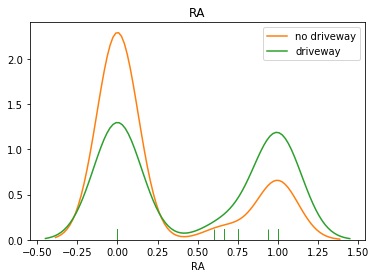

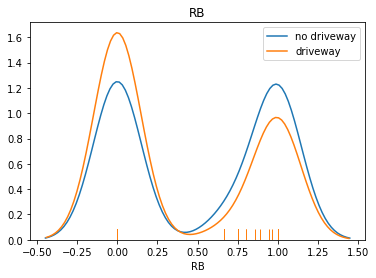

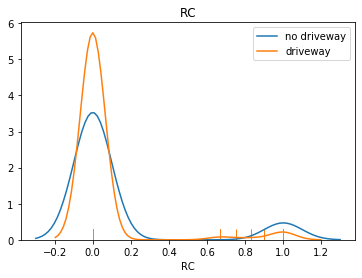

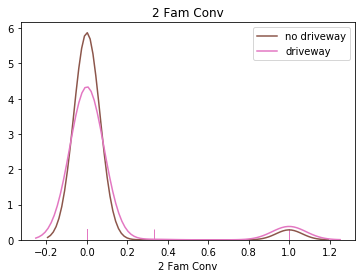

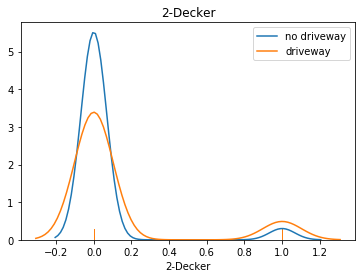

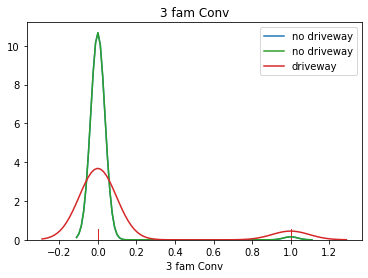

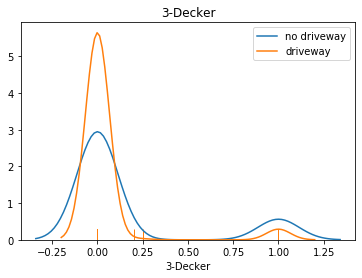

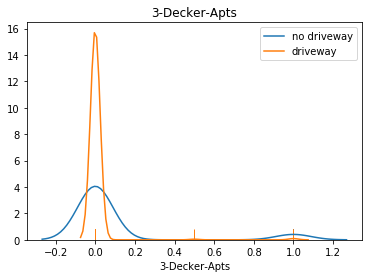

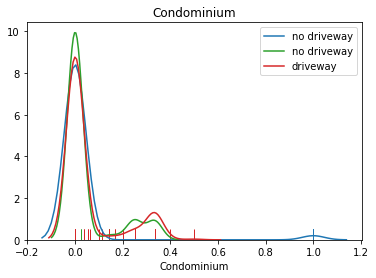

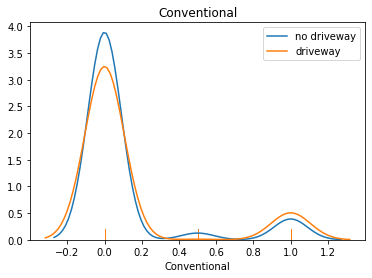

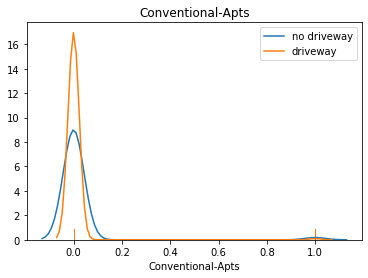

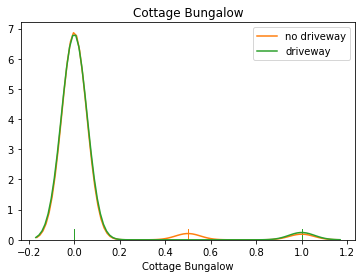

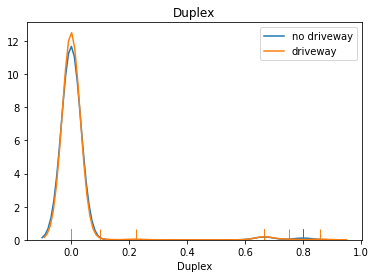

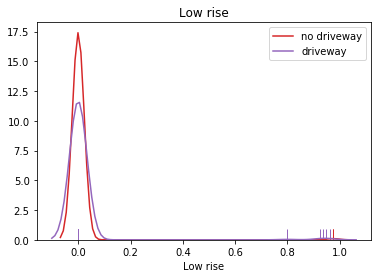

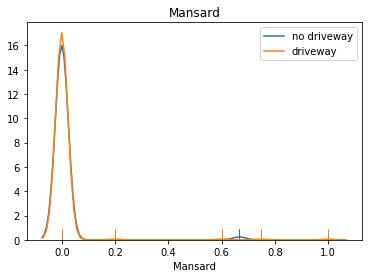

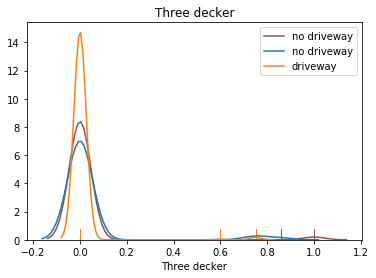

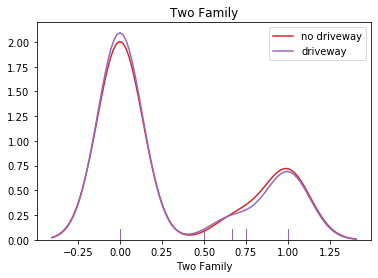

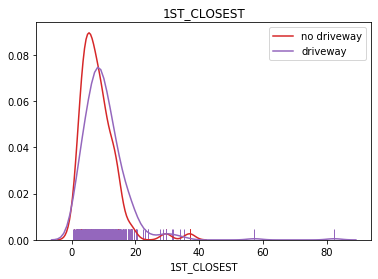

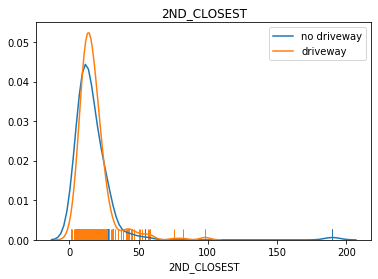

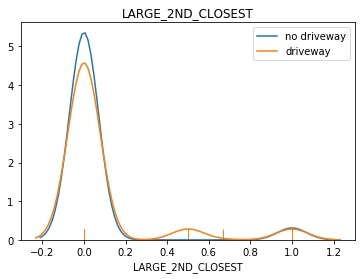

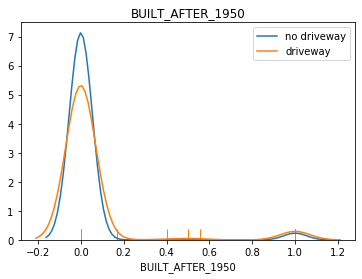

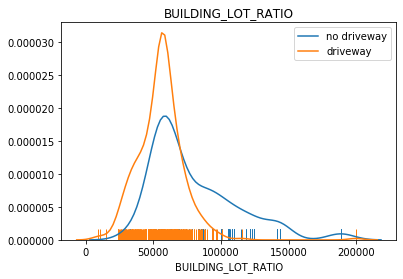

In [90]:
for clm in df_viz.columns:
    try:
        sns.distplot(df_viz[df.final_label == 0][clm], label = 'no driveway', rug=True, hist=False)
        sns.distplot(df_viz[df.final_label == 1][clm], label = 'driveway', rug=True, hist=False)
        plt.legend()
        plt.title(clm)
        plt.show()
    except:
        pass

In [91]:
for idx, x in enumerate(df_viz.corr()['final_label']):
    print(df_viz.corr()['final_label'].index[idx])
    print(x)

Unnamed: 0
-0.014576472498925729
AERIAL_Garage
-0.02172171791076066
GSV_Garage
0.06741757649557396
final_label
1.0
BLDG_VAL
-0.1510436197232706
LAND_VAL
0.05909636012206338
OTHER_VAL
-0.15298110529025688
LOT_SIZE
0.19665888122106776
LS_PRICE
-0.0987971066271127
YEAR_BUILT
0.09002798186664415
BLD_AREA
-0.1287109689588557
UNITS
0.0034995362940196564
RES_AREA
-0.14695757909136503
STORIES
-0.13605621635961768
NUM_ROOMS
-0.1653046103335091
LOT_UNITS
0.03190598765008259
BLD_AREA_MISSING
0.033536925819543886
BLDG_VAL_MISSING
0.07845949177925338
LOT_SIZE_MISSING
0.0658901583591173
LS_YEAR
0.001898630148830802
101
0.03073935138962856
102
nan
104
nan
105
0.07919376321631438
111
-0.07164200712813379
112
nan
130
nan
322
0.07919376321631583
325
nan
326
nan
332
nan
340
-0.06431884133905981
995
0.07845949177925338
1010
0.06435035353396198
1020
0.06242945215298598
1040
0.0342795760009135
1050
-0.04152744121228505
1090
nan
1110
-0.1669995484134307
1120
-0.06200291261242852
1220
nan
9450
0.0307393513896

# Prep Data

In [32]:
df = df[df.final_label != 2]

df_train, df_test = train_test_split(df, test_size = 0.25)

df_train_up = upsample(df_train)
df_test_up = upsample(df_test)

In [33]:
X_train, y_train = df_train_up[tabular.columns].drop('MBL', axis = 1), df_train_up['final_label']
X_test, y_test = df_test_up[tabular.columns].drop('MBL', axis = 1), df_test_up['final_label']
X_test_original, y_test_original = df_test[tabular.columns].drop('MBL', axis = 1), df_test['final_label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_original = scaler.transform(X_test_original)
# poly = PolynomialFeatures(degree = 1)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

y_test = y_test.apply(lambda x: 1 if x > .5 else 0)
y_train = y_train.apply(lambda x: 1 if x > .5 else 0)
y_test_original = y_test_original.apply(lambda x: 1 if x > .5 else 0)

In [34]:
X_train.shape

(520, 103)

In [35]:
y_train.value_counts()

1    260
0    260
Name: final_label, dtype: int64

In [36]:
X_test.shape

(180, 103)

In [37]:
y_test.value_counts()

1    90
0    90
Name: final_label, dtype: int64

# Logistic Regression

In [38]:
lr = LogisticRegression(C = 1e30, penalty = 'l2', max_iter = 300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[61 29]
 [25 65]]
              precision    recall  f1-score   support

           0       0.71      0.68      0.69        90
           1       0.69      0.72      0.71        90

    accuracy                           0.70       180
   macro avg       0.70      0.70      0.70       180
weighted avg       0.70      0.70      0.70       180



/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
# validate on original data
y_pred_original = lr.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

[[11  5]
 [25 65]]
              precision    recall  f1-score   support

           0       0.31      0.69      0.42        16
           1       0.93      0.72      0.81        90

    accuracy                           0.72       106
   macro avg       0.62      0.70      0.62       106
weighted avg       0.83      0.72      0.75       106



In [50]:
y_pred_original[:,1] > .8

array([False, False,  True,  True, False, False, False,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True, False,
        True,  True, False,  True, False, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
       False,  True,  True, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True, False, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True])

In [65]:
# validate on original certain
# validate on original data
y_pred_original_proba = lr.predict_proba(X_test_original)
y_pred_original = lr.predict(X_test_original)
threshold = .45
is_certain_pred = np.absolute(y_pred_original_proba[:,1] - 0.5) > threshold
print(classification_report(y_test_original[is_certain_pred],y_pred_original[is_certain_pred]))


              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.97      0.88      0.92        34

    accuracy                           0.87        38
   macro avg       0.70      0.82      0.73        38
weighted avg       0.91      0.87      0.88        38



In [66]:
df_test[y_test_original != y_pred_original]

,Unnamed: 0,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,AERIAL_Garage,GSV_Driveway,GSV_Garage,final_label,...,Townhouse middle,Two Family,Two Family-Apts,Two decker,Victorian,1ST_CLOSEST,2ND_CLOSEST,LARGE_2ND_CLOSEST,BUILT_AFTER_1950,BUILDING_LOT_RATIO
262,6237,33,DERBY ST,69-H-24,"33 DERBY ST, SOMERVILLE, MA",1.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,3.659358,8.952455,0.0,0.000000,64850.000000
289,5126,45,GREENVILLE ST,80-G-5,"45 GREENVILLE ST, SOMERVILLE, MA",1.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,11.354407,17.009064,0.0,0.000000,77650.000000
456,1199,11,FREMONT AVE,75-C-5,"11 FREMONT AVE, SOMERVILLE, MA",0.0,2.0,0.0,2.0,0,...,0.0,0.000000,0.0,0.0,0.0,9.137360,9.895398,0.0,0.000000,50440.000000
357,11241,244,CEDAR ST,27-E-30,"244 CEDAR ST, SOMERVILLE, MA",1.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,14.149683,14.182474,0.0,0.000000,80400.000000
269,2337,36,CORINTHIAN RD,12-C-19,"36 CORINTHIAN RD, SOMERVILLE, MA",1.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,12.963231,13.177968,0.0,0.000000,45775.000000
76,12881,41R,PEARL ST,103-G-10,"41R PEARL ST, SOMERVILLE, MA",1.0,2.0,2.0,2.0,1,...,0.0,0.000000,0.0,0.2,0.0,6.192736,7.707454,0.0,0.000000,56885.764389
121,9064,67,WINSLOW AVE,24-H-7,"67 WINSLOW AVE, SOMERVILLE, MA",2.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,8.382208,10.945525,0.0,0.000000,76157.142857
29,7627,8,BEACON TERR,31-C-32,"8 BEACON TERR, SOMERVILLE, MA",1.0,2.0,2.0,2.0,1,...,0.0,1.000000,0.0,0.0,0.0,12.082055,13.074231,0.0,0.000000,47371.428571
272,2402,36,PENNSYLVANIA AVE,102-E-2,"36 PENNSYLVANIA AVE, SOMERVILLE, MA",1.0,2.0,1.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,4.726620,8.970327,0.0,0.000000,59180.000000
69,10969,326,BROADWAY,59-C-22,"326 BROADWAY, SOMERVILLE, MA",1.0,2.0,2.0,2.0,1,...,0.0,0.000000,0.0,0.0,0.0,9.576481,45.506429,1.0,1.000000,56885.764389


In [41]:
dict(zip(df_test[tabular.columns].drop('MBL', axis = 1).columns, lr.coef_.reshape(-1)))

{'BLDG_VAL': 2.123426002880747,
 'LAND_VAL': -0.1915159856248403,
 'OTHER_VAL': 0.059529560790335743,
 'LOT_SIZE': 0.8483005551295538,
 'LS_PRICE': -0.31041496827374926,
 'YEAR_BUILT': -0.2048739438612307,
 'BLD_AREA': -1.8294540507173414,
 'UNITS': 4.980707626228609,
 'RES_AREA': 0.39450970995809065,
 'STORIES': 0.477963367180596,
 'NUM_ROOMS': 0.190922952264696,
 'LOT_UNITS': 0.2827592263456283,
 'BLD_AREA_MISSING': -0.10765786274191629,
 'BLDG_VAL_MISSING': 7.3066908824599,
 'LOT_SIZE_MISSING': -3.2522367794000506,
 'LS_YEAR': 0.15996555725535822,
 '101': 0.6251644761227909,
 '102': 0.0,
 '104': 0.0,
 '105': 0.0,
 '111': 0.0,
 '112': 0.0,
 '130': 0.0,
 '322': 0.0,
 '325': 0.0,
 '326': 0.0,
 '332': 0.0,
 '340': 0.7086765671484526,
 '995': 7.3066908824599,
 '1010': 5.603541506282011,
 '1020': -8.224252922911298,
 '1040': -0.7361783310424584,
 '1050': 0.1583709734880816,
 '1090': 0.0,
 '1110': -0.40604793926281807,
 '1120': -0.09511006506728281,
 '1220': 0.0,
 '9450': 1.666699006579355

In [67]:
y_pred_original = lr.predict(X_test_original)
y_pred_original

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [68]:
sum(y_pred_original == y_test_original)/len(y_test_original)

0.7169811320754716

In [69]:
y_test_original.value_counts()

1    90
0    16
Name: final_label, dtype: int64

In [70]:
tn, fp, fn, tp = confusion_matrix(y_test_original, y_pred_original).ravel()
(tn, fp, fn, tp)

(11, 5, 25, 65)

# Support Vector Machine

In [71]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree = 1)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

y_pred_original = svclassifier.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

[[54 36]
 [27 63]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        90
           1       0.64      0.70      0.67        90

    accuracy                           0.65       180
   macro avg       0.65      0.65      0.65       180
weighted avg       0.65      0.65      0.65       180

[[ 9  7]
 [27 63]]
              precision    recall  f1-score   support

           0       0.25      0.56      0.35        16
           1       0.90      0.70      0.79        90

    accuracy                           0.68       106
   macro avg       0.57      0.63      0.57       106
weighted avg       0.80      0.68      0.72       106



/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Decision Tree

In [74]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

y_pred_original = clf.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

[[24 66]
 [25 65]]
              precision    recall  f1-score   support

           0       0.49      0.27      0.35        90
           1       0.50      0.72      0.59        90

    accuracy                           0.49       180
   macro avg       0.49      0.49      0.47       180
weighted avg       0.49      0.49      0.47       180

[[ 5 11]
 [25 65]]
              precision    recall  f1-score   support

           0       0.17      0.31      0.22        16
           1       0.86      0.72      0.78        90

    accuracy                           0.66       106
   macro avg       0.51      0.52      0.50       106
weighted avg       0.75      0.66      0.70       106



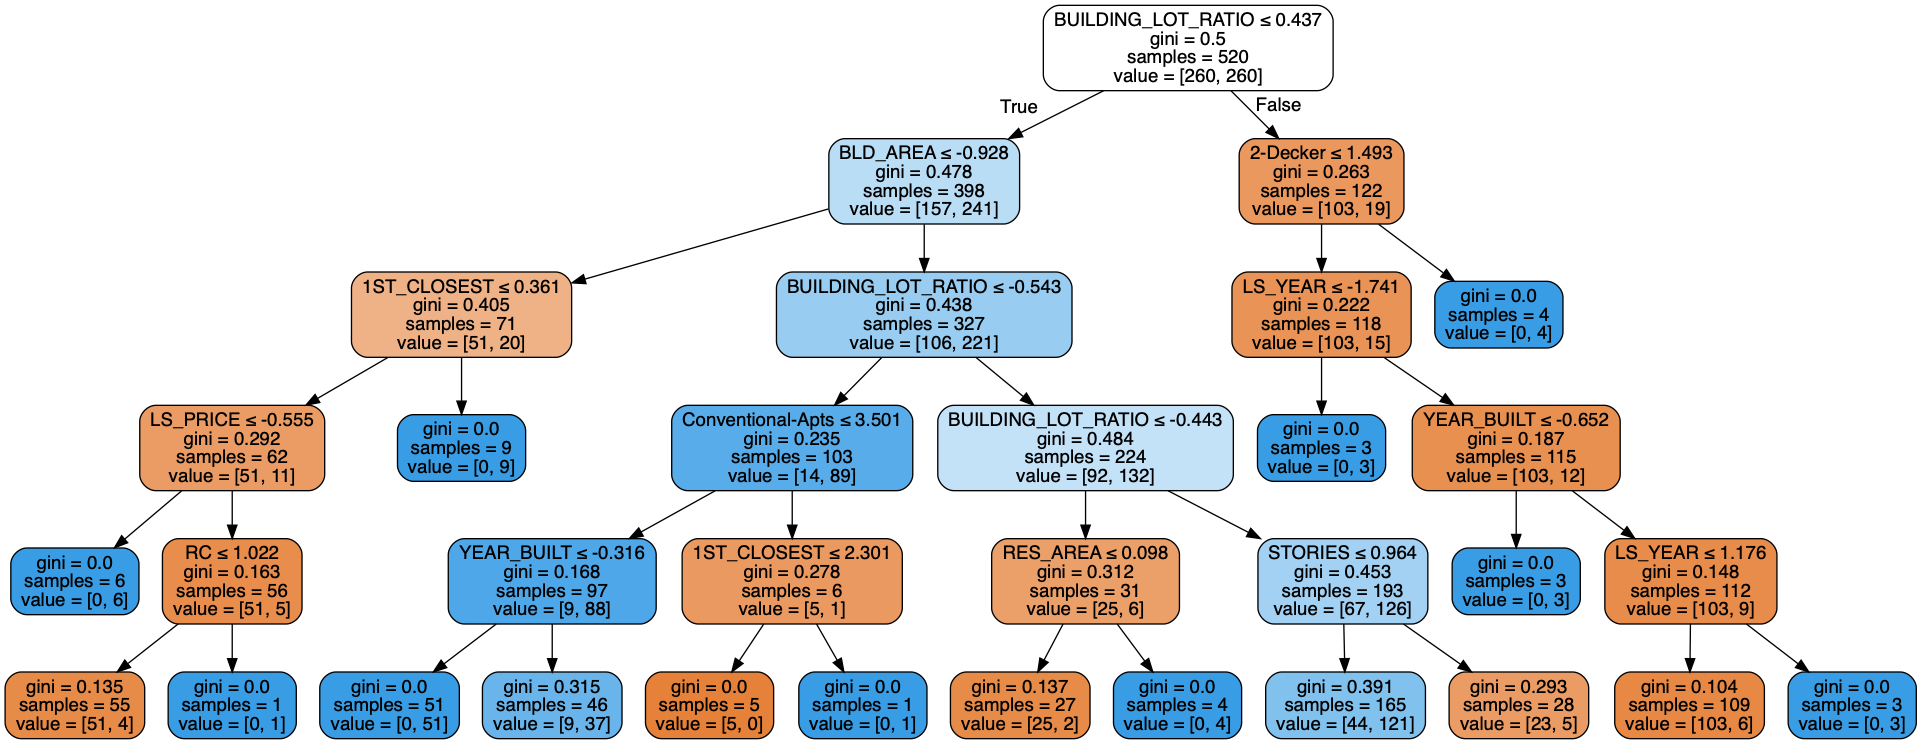

In [75]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = df_test[tabular.columns].drop('MBL', axis = 1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# XGBoost

In [76]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [77]:
try:
    df = df.drop(['MBL','AERIAL_Driveway', 'GSV_Driveway'], axis = 1)
except KeyError:
    pass

df.final_label = df.final_label.apply(lambda x: 1 if x > .5 else 0)

train = df
target = 'final_label'
IDcol = 'MBL'

In [78]:
count = train.final_label.value_counts()
scale = count[0]/count[1]

In [79]:
def modelfit(alg, dtrain, predictors, cv_folds=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    print(cvresult.shape[0])
    return cvresult.shape[0]

In [80]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale,
 seed=27)

predictors = [x for x in train.columns if x not in [target, IDcol]]
best_n_estimators = modelfit(xgb1, train, predictors)

ValueError: could not convert string to float: 'DOUGLAS AVE'

In [97]:
param_test1 = {
 'max_depth':[2,3,4],
 'min_child_weight':[5,6,7]
}

gsearch1 = (
    GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=best_n_estimators, max_depth=5,
                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                 objective= 'binary:logistic', nthread=4, scale_pos_weight=scale, seed=27), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.2055512 , 0.18483911, 0.18603506, 0.25352445, 0.2216042 ,
         0.18995218, 0.24034986, 0.24768362, 0.19593678]),
  'std_fit_time': array([0.03976696, 0.01935333, 0.01541849, 0.00922613, 0.01594204,
         0.01302306, 0.01058092, 0.00847355, 0.02380416]),
  'mean_score_time': array([0.00935044, 0.0052104 , 0.00491176, 0.00511384, 0.0049037 ,
         0.00496464, 0.00500336, 0.00554757, 0.00550838]),
  'std_score_time': array([3.84968710e-03, 1.25344064e-04, 1.69764918e-04, 2.29349900e-04,
         1.85212085e-04, 7.17644517e-05, 3.57695910e-04, 6.88544773e-04,
         1.35365386e-03]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[5, 6, 7, 5, 6, 7, 5, 6, 7],
               mask=[False, False, False, False, False, False, False, 

In [98]:
gsearch1.best_params_

{'max_depth': 2, 'min_child_weight': 7}

In [99]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(
    estimator = XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=best_n_estimators, 
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'], 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=scale,
        seed=27), 
    param_grid = param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.20898037, 0.17659345, 0.19749889, 0.21077614, 0.17452111]),
  'std_fit_time': array([0.01320666, 0.01531133, 0.03034501, 0.02356491, 0.04096853]),
  'mean_score_time': array([0.00597625, 0.00522981, 0.00511389, 0.00493884, 0.00889931]),
  'std_score_time': array([0.0006195 , 0.00038067, 0.0002802 , 0.0001945 , 0.00866138]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.57047619, 0.57047619, 0.57047619, 0.57047619, 0.56952381]),
  'split1_test_score': array([0.66380952, 0.66380952, 0.66380952, 0.66380952, 0.66380952]),
  'split2_test_score': array([0.72653061, 0.72653061, 0.72653061, 0.71428571, 0.71428571]),
  'split3_test_score': array([0.69693878, 0.69693878, 0.69693878, 0.69081633, 0.68367347]),

In [100]:
xgb2 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)
best_n_estimators = modelfit(xgb2, train, predictors)

56


In [101]:
xgb3 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=best_n_estimators, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)

In [102]:
# fit model
train, test = train_test_split(df, test_size = 0.2)

In [103]:
xgb3.fit(train[predictors], train[target])
y_pred = xgb3.predict(test[predictors])
sum(y_pred == test[target])/len(test[target])

0.6352941176470588

In [104]:
confusion_matrix(y_pred, test[target])

array([[ 7, 26],
       [ 5, 47]])